In [1]:
import stlearn as st
import scanpy  as sc
import markupsafe
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
os.environ['NUMBA_DISABLE_INTEL_SVML'] = '1'

/home/yqcj/miniconda3/envs/scrublet/lib/python3.9/site-packages/stlearn/tools/microenv/cci/het.py:192: NumbaDeprecationWarning: The keyword argument 'nopython=False' was supplied. From Numba 0.59.0 the default is being changed to True and use of 'nopython=False' will raise a warning as the argument will have no effect. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit(parallel=True, nopython=False)


In [3]:
data=st.Read10X(path='/mnt/c/Users/YsComputer/Desktop/SCSP/ST_matrix2/ST/ST-colon1',count_file ='filtered_feature_bc_matrix.h5')
data.var_names_make_unique

<bound method AnnData.var_names_make_unique of AnnData object with n_obs × n_vars = 3313 × 36601
    obs: 'in_tissue', 'array_row', 'array_col', 'imagecol', 'imagerow'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'>

In [4]:
# 基因过滤
st.pp.filter_genes(data, min_cells=3)
# 测序深度校正
st.pp.normalize_total(data)
# log转化
st.pp.log1p(data)


Normalization step is finished in adata.X
Log transformation step is finished in adata.X


In [5]:
# 图像分割
st.pp.tiling(data,out_path="/mnt/c/Users/YsComputer/Desktop/SCSP/ST_matrix2/ST/ST-colon1/stlearn",crop_size = 40)
# 深度学习识别图像特征

Tiling image: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ [ time left: 00:00 ]


In [6]:
#使Warning变少
from warnings import simplefilter
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)

st.pp.extract_feature(data)

2023-08-16 11:59:33.006774: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-16 11:59:33.164304: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-08-16 11:59:33.164372: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-08-16 11:59:34.087404: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

In [7]:
# PCA降维
st.em.run_pca(data,n_comps=50,random_state=0)

In [8]:
data.write('ST-colon1_noscaled_beforeSME.h5ad',compression='gzip')

In [2]:
data=sc.read('ST-colon1_noscaled_beforeSME.h5ad')

In [3]:
data_normal = data.copy()

In [6]:
data_SME = data.copy()
st.spatial.SME.SME_normalize(data_SME, use_data="raw")
data_SME.X = data_SME.obsm['raw_SME_normalized']
st.em.run_pca(data_SME,n_comps=50)

Adjusting data: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ [ time left: 00:00 ]


The data adjusted by SME is added to adata.obsm['raw_SME_normalized']
PCA is done! Generated in adata.obsm['X_pca'], adata.uns['pca'] and adata.varm['PCs']


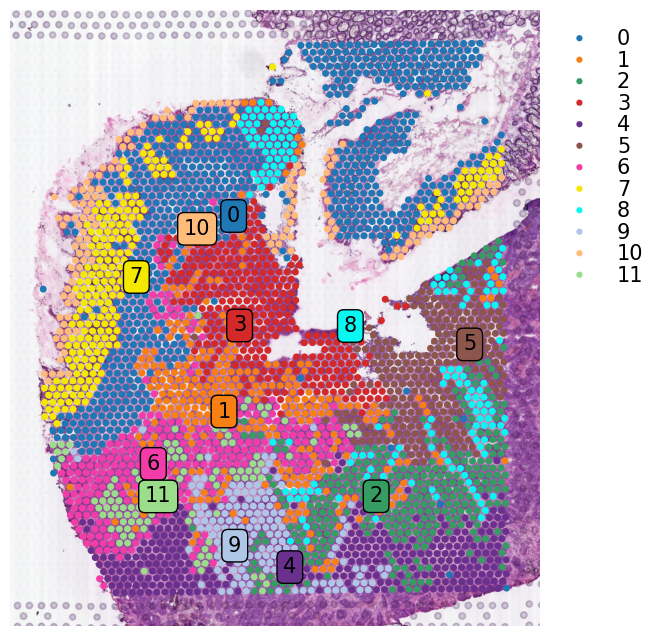

In [139]:
## leiden聚类
import scanpy as sc
sc.tl.leiden(data_SME, key_added="leiden",resolution=0.8)
st.pl.cluster_plot(data_SME, use_label="leiden", image_alpha=1,size=25, figsize=(8,8),
                   show_cluster_labels=True, text_box_size=15, color_bar_size=15)
plt.savefig(str(OUT_PATH) + "/with_SME_"+'leiden_cluster.pdf')

In [152]:
import pandas as pd
import scanpy as sc

# 读取CSV文件
decon_mat = pd.read_csv("spotlight_decon_mat_for_fib_epi_sub.csv", index_col=0)

# 获取'celltype'列的值
celltype = decon_mat['celltype']

# 将'celltype'列添加到data_SME的obs属性中
data_SME.obs['Celltype'] = celltype

In [153]:
data_SME.obs['Celltype'] = data_SME.obs['Celltype'].astype('category')

In [154]:
data_SME.obs['Celltype']

AAACAAGTATCTCCCA-1                NaN
AAACACCAATAACTGC-1    Malignant EPCs8
AAACAGAGCGACTCCT-1                NaN
AAACAGTGTTCCTGGG-1                NaN
AAACATTTCCCGGATT-1    Malignant EPCs8
                           ...       
TTGTTGTGTGTCAAGA-1    Malignant EPCs8
TTGTTTCACATCCAGG-1    Malignant EPCs8
TTGTTTCATTAGTCTA-1    Malignant EPCs8
TTGTTTCCATACAACT-1                NaN
TTGTTTGTATTACACG-1                NaN
Name: Celltype, Length: 3313, dtype: category
Categories (3, object): ['CXCL1+ CAFs', 'Malignant EPCs8', 'SFRP2+ CAFs']

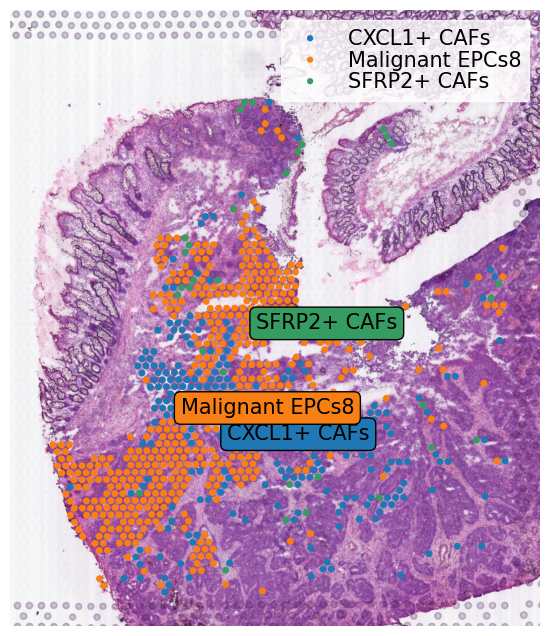

In [143]:
## leiden聚类
import scanpy as sc
st.pl.cluster_plot(data_SME, use_label="Celltype", image_alpha=1,size=25, figsize=(8,8),
                   show_cluster_labels=True, text_box_size=15, color_bar_size=15)
plt.savefig(str(OUT_PATH) + "/with_SME_"+'Celltype_cluster.pdf')

In [197]:
data_SME.uns["iroot"] = st.spatial.trajectory.set_root(data_SME,use_label="leiden",cluster=3,use_raw=False)
st.spatial.trajectory.pseudotime(data_SME,eps=50,use_rep="X_pca",use_label="leiden")

/home/yqcj/miniconda3/envs/scrublet/lib/python3.9/site-packages/stlearn/spatials/trajectory/set_root.py:40: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  tmp_adata.var["gene_corr"] = gene_corr


All available trajectory paths are stored in adata.uns['available_paths'] with length < 4 nodes


In [198]:
st.spatial.trajectory.pseudotimespace_global(data_SME,use_label="leiden",list_clusters=["3","1"])

Start to construct the trajectory: 3 -> 1


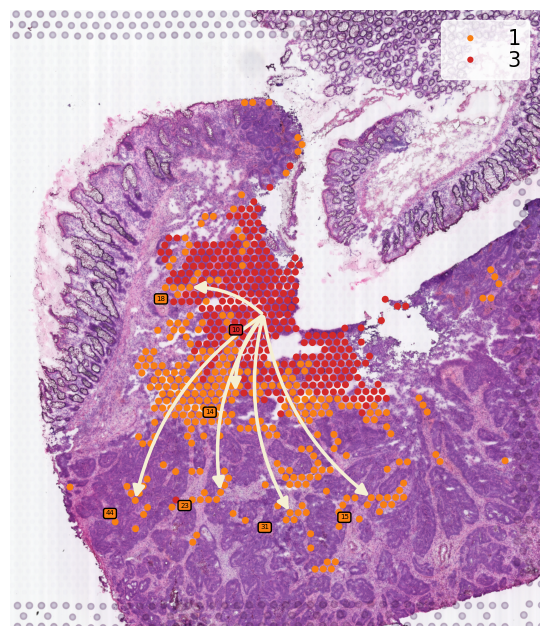

In [199]:
st.pl.cluster_plot(data_SME,use_label="leiden",show_trajectories=True,list_clusters=["3","1"],
                   show_subcluster=True, size=25, figsize=(8,8), color_bar_size=15)
plt.savefig(str(OUT_PATH) + "/with_SME_"+'_trace_3-1.pdf')

In [200]:
data_SME.uns["iroot"] = st.spatial.trajectory.set_root(data_SME,use_label="leiden",cluster=6,use_raw=False)
st.spatial.trajectory.pseudotime(data_SME,eps=50,use_rep="X_pca",use_label="leiden")

/home/yqcj/miniconda3/envs/scrublet/lib/python3.9/site-packages/stlearn/spatials/trajectory/set_root.py:40: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  tmp_adata.var["gene_corr"] = gene_corr


All available trajectory paths are stored in adata.uns['available_paths'] with length < 4 nodes


In [201]:
st.spatial.trajectory.pseudotimespace_global(data_SME,use_label="leiden",list_clusters=["6","1"])

Start to construct the trajectory: 6 -> 1


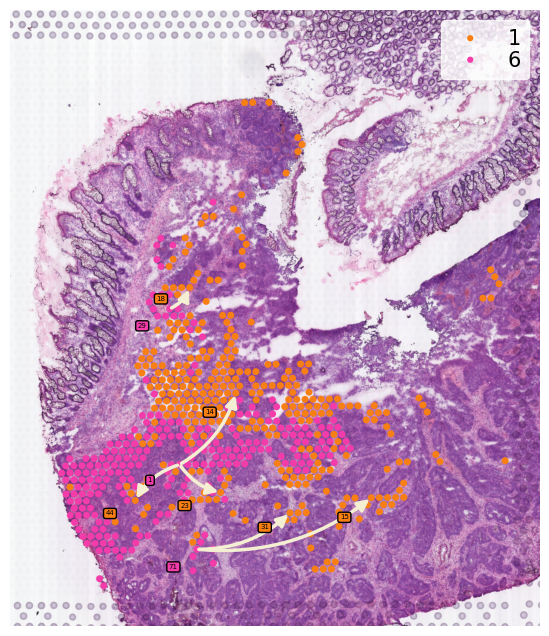

In [203]:
st.pl.cluster_plot(data_SME,use_label="leiden",show_trajectories=True,list_clusters=["6","1"],
                   show_subcluster=True, size=25, figsize=(8,8), color_bar_size=15)
plt.savefig(str(OUT_PATH) + "/with_SME_"+'_trace_6-1.pdf')

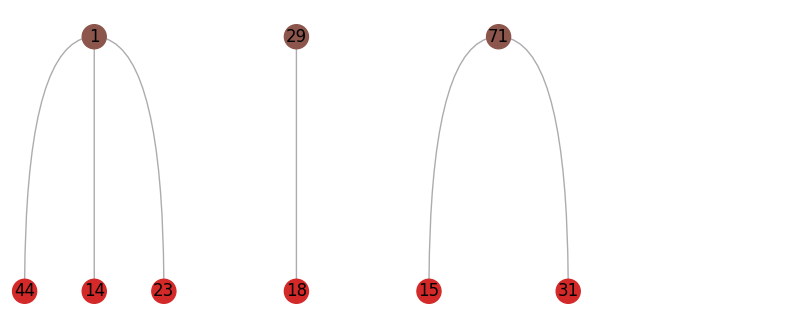

In [205]:
st.pl.trajectory.tree_plot(data_SME)